In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('./cifar-10-batches-py/data_batch_1', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')

print(d.keys())
data = d[b'data']
labels = d[b'labels']
print(data[0])

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
[ 59  43  50 ... 140  84  72]


In [3]:
# takes 1D array of pixel data and converts to MxNx3 RGB format
def reshape_img(pixeldata, m, n):
    return np.rot90(pixeldata.reshape((m, n, 3), order='F'), 3)

In [4]:
image_data = [reshape_img(img, 32, 32) for img in data]

In [5]:
label_strs = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def class_str(class_index):
    return label_strs[class_index]

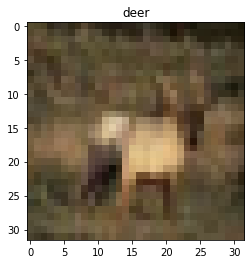

In [6]:
def display(image, index=-1):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if index >= 0:
        ax.set_title(class_str(labels[index]))
    plt.imshow(image)
    plt.show()

display(image_data[3], 3)

In [7]:
# Adding this AFTER I've made the CNN forward prop: we need
# to convert the classes given to us to one-hot-encoded vectors

def one_hot(label, num_labels):
    oh = np.zeros((num_labels))
    oh[label] = 1
    return oh

print(one_hot(5, 10))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
# Great, so now we have our image data in a good format. 

# Let's first try to make sense of how a CNN is structured

# We'll separate our data into training and testing groups later

### Convolutional Neural Network (CNN)
We have our input image, structured in a MxNx3 format (3 dimensions for R, G, and B values) 

The input image generally feeds directly into a convolutional layer. A convolutional layer is made up of multiple filters, each of the same size. Filters have a size, let's say fxf, where each value is a weight. We can think of the filters as a sort of sliding window that goes across and down its input. The filters also have a "stride," which is a measure of how quickly the filter "slides" across its input (ie. how many pixels does it jump)

Let's say we have F filters. S = stride. The output layer will be of size ((InpSize - F)/S + 1). 

In [56]:
# Okay then, we'll attempt a convolutional layer.

class ConvLayer:
    
    def __init__(self, num_filters, filter_size, inp_depth, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        
        # initialize filters randomly (divide by filter_size^2 to normalize)
        self.filters = np.random.randn(num_filters, filter_size, filter_size, inp_depth) / (filter_size**2)
        # self.filters = [[[0.1, 0.1], [0.1, 0.1]], [[0.2, 0.2], [0.2, 0.2]]]
    
    
    '''
    convolve takes a filter-sized patch of the image,
    a filter itself, and performs the convolve operation,
    returning a single sum
    '''
    def convolve(self, patch, f):
        s = 0
        height, width, depth = patch.shape
        for d in range(depth):
            for h in range(height):
                for w in range(width):
                    s += f[h][w]*patch[h][w][d]
        return s
    
    
    '''
    get_patch returns a filter-sized patch of the image,
    given an i,j coordinate (upper-left pixel)
    '''
    def get_patch(self, image, i, j):
        return image[i:(i+self.filter_size), j:(j+self.filter_size)]
        
    
    '''
    Forward propagation
    '''
    def forward_prop(self, image):
        self.image = image
        
        inp_height, inp_width, d = image.shape
        h_strides = int((inp_width - self.filter_size) / self.stride + 1)
        v_strides = int((inp_height - self.filter_size) / self.stride + 1)
        
        self.out_size = (h_strides, v_strides, self.num_filters)
        conv_out = np.zeros(self.out_size)
        
        for f, fltr in enumerate(self.filters):
            for i in range(0, v_strides):
                for j in range(0, h_strides):
                    conv_out[i, j, f] = np.sum(self.get_patch(image, i*self.stride, j*self.stride) * fltr)
                    # self.convolve(self.get_patch(image, i*self.stride, j*self.stride), fltr)
        return conv_out
    
    '''
    Backward propagation
    dL_dout - will be the gradients from the next ConvLayer
            (or the softmax layer if this is the last ConvLayer)
    learning_rate - parameter for updating weights 
    '''
    def backward_prop(self, dL_dout, learning_rate):
        dL_dW_params = np.zeros(self.filters.shape)
        
        h, w, d = self.image.shape
        h_strides, v_strides, nfilters = self.out_size   
        
        for i in range(h_strides):
            for j in range(v_strides):
                for f in range(nfilters):
                    for layer in range(d):
                        dL_dW_params[f] += self.get_patch(self.image, i*self.stride, j*self.stride) * dL_dout[i][j][f]

        self.filters -= learning_rate * dL_dW_params
        return dL_dW_params
        

In [177]:
# this is just a quick test of the forward prop math
D = ConvLayer(num_filters=2, filter_size=2, inp_depth=3)
test_img = np.array([
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
])
print(D.forward_prop(test_img))

[[[-1.87524067 -3.31458369]
  [-3.62844418 -5.63009687]]

 [[-1.87524067 -3.31458369]
  [-3.62844418 -5.63009687]]]


(29, 29, 10)


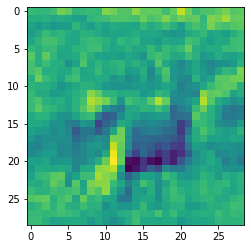

In [178]:
L = ConvLayer(num_filters=10, filter_size=4, inp_depth=3)
conv_out = L.forward_prop(image_data[3])
print(conv_out.shape)

# output of a single conv layer (one slice)
plt.imshow(conv_out[:,:,9])

In [59]:
# At the end of our sequence of ConvLayers, we'll need to flatten
# whatever output we get, in order to be fed into a softmax layer

# It doesn't *exactly* matter how we go about flattening this layer.
# The model will learn the patterns regardless of this layer's ordering
# (at least I think)

# EDIT: I'm just going to include this in the Softmax layer
# EDIT2: numpy has a built-in flatten function, I'll use that instead

def flatten(conv_out):
    height, width, depth = conv_out.shape
    out = np.zeros((height*width*depth,))
    i = 0
    for d in range(depth):
        for h in range(height):
            for w in range(width):
                out[i] = conv_out[h][w][d]
                i += 1
    
    return out

print(flatten(np.array([
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
])))

print(np.array([
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
]).flatten())

[1. 4. 7. 2. 5. 8. 3. 6. 9.]
[1 2 3 4 5 6 7 8 9]


In [194]:
# After the convolutional layer, we'll want to put our image thru
# a pooling layer. 

class MaxPoolLayer:
    
    def __init__(self, filter_size):
        self.filter_size = filter_size
        
    
    '''
    * used from ConvLayer *
    get_patch returns a filter-sized patch of the image,
    given an i,j coordinate (upper-left pixel)
    '''
    def get_patch(self, image, i, j):
        return image[i:(i+self.filter_size), j:(j+self.filter_size)]
    
    
    def forward_prop(self, image):
        self.image = image
        height, width, nfilters = image.shape
        
        self.out_size = (height // self.filter_size, width // self.filter_size, nfilters)
        out = np.zeros(self.out_size)
        
        for i in range(self.out_size[0]):
            for j in range(self.out_size[1]):
                out[i][j] = np.amax(self.get_patch(image, i*self.filter_size, j*self.filter_size), axis=(0,1))
                
        return out
    
    def backward_prop(self, dL_dout, learning_rate):
        dL_dMP = np.zeros(self.image.shape)
        height, width, nfilters = self.out_size
        
        for i in range(height):
            for j in range(width):
                image_patch = self.get_patch(self.image, i*self.filter_size, j*self.filter_size)
                max_val = np.amax(image_patch, axis=(0,1))
                h, w, f = image_patch.shape
                
                # iterate over inp image and 
                for ip in range(h):
                    for jp in range(w):
                        for fp in range(f):
                            if image_patch[ip][jp][fp] == max_val[fp]:
                                dL_dMP[i*self.filter_size + ip][j*self.filter_size + jp][fp] = dL_dout[i, j, fp]
                                
        return dL_dMP
        

In [179]:
# Let's test out forward prop

img = image_data[5]
M_P = MaxPoolLayer(2)
mp_out = M_P.forward_prop(conv_out)

print(conv_out.shape)
print(mp_out.shape)

(29, 29, 10)
(14, 14, 10)


In [195]:
# Now I guess we can start creating our softmax layer. 

# This layer takes a single-dimensional input, and gives an 
# output of size C, where C is # of classes we're training

class SoftmaxLayer:
    
    '''
    num_inputs - the total size of the output of the previous ConvLayer
    num_classes - number of classes we are training to predict
    '''
    def __init__(self, num_inputs, num_classes):
        
        # initialize weights & biases
        self.weights = np.random.randn(num_inputs, num_classes) / num_inputs
        self.biases = np.zeros(num_classes)
    
    
    '''
    Forward propagation, Softmax layer
    
    img - will be the "box" of z outputs from the last ConvLayer
    '''
    def forward_prop(self, img):
        
        # these will be used in backward propagation
        self.orig_img_shape = img.shape
        flattened = img.flatten()
        self.flattened = flattened
        # print('flattened fc layer: ', flattened)
        
        # this is our z values out of the FC layer
        out_val = np.dot(flattened, self.weights) + self.biases
        self.output = out_val
        
        # e^(z_i)
        exp_out = np.exp(self.output)
        
         # this is our y_hat predictions
        return exp_out / np.sum(exp_out, axis=0)
    
    
    '''
    Backward propagation, Softmax layer
    
    dL_dout - will be given from our model's main function - it is
    going to be the cross-entropy loss
    
    learning_rate - model's learning rate
    '''
    def backward_prop(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue
            
            exp = np.exp(self.output)
            S_total = np.sum(exp)
            
            # case 2: i != l
            dy_dz = -exp[i] * exp / (S_total**2)
            
            # case 1: i == l (this is equiv. to y*(1-y))
            dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)
            
            # dz_dw, dz_db, dz_dinput
            dz_dw = self.flattened
            dz_db = 1
            dz_dinput = self.weights
            
            # grad is dL_dy
            # dL/dz = dL/dy * dy/dz
            dL_dz = grad * dy_dz
            
            # loss wrt. weights, biases, input
            dL_dW = np.dot(dz_dw[np.newaxis].T, dL_dz[np.newaxis])
            dL_db = dL_dz * dz_db
            dL_dinput = np.dot(dz_dinput, dL_dz)
            
            # update weights and biases
            self.weights = self.weights - (learning_rate * dL_dW)
            self.biases = self.biases - (learning_rate * dL_db)
            
            return dL_dinput.reshape(self.orig_img_shape)
            

In [186]:
from math import prod
sm = SoftmaxLayer(prod(mp_out.shape), 10)
softmax_out = sm.forward_prop(mp_out)

print(softmax_out)


flattened:  186.4808540704952
[0.20694686 0.06600033 0.02497304 0.21801773 0.08808075 0.0777726
 0.08469937 0.15677403 0.04971776 0.02701752]


In [64]:
# Test run of one image forward prop thru whole model

img = image_data[5]
Conv1 = ConvLayer(num_filters=4, filter_size=4, inp_depth=3, stride=1)
MP1 = MaxPoolLayer(2)

# forward prop thru ConvLayers
c1_out = Conv1.forward_prop(img)
mp1_out = MP1.forward_prop(c1_out)

print(mp1_out.shape)

# softmax
softmax = SoftmaxLayer(prod(mp1_out.shape), 10)
softmax_out = softmax.forward_prop(mp1_out)

print(softmax_out)

(14, 14, 4)
[1.52908715e-04 5.85639091e-03 1.21478269e-01 2.48066778e-02
 1.31850018e-02 2.82051643e-03 8.06788190e-01 2.11445690e-02
 2.22753211e-03 1.53994445e-03]


### Calculating Cross-Entropy Loss
Cross-entropy loss: 


In [65]:
# Test run of one image thru backpropagation

learning_rate = 0.01

l = 5
oh_l = one_hot(labels[l], 10)
cross_entropy_loss = -np.log(softmax_out[l])
accuracy = 0
if np.argmax(softmax_out) == l:
    accuracy = 1
    
gradient = np.zeros(10)
gradient[l] = -1/softmax_out[l]

backprop = softmax.backward_prop(gradient, learning_rate)
backprop = MP1.backward_prop(backprop, learning_rate)
backprop = Conv1.backward_prop(backprop, learning_rate)
print('conv backprop gradients shape: ', backprop.shape)

print(cross_entropy_loss, accuracy)

conv backprop gradients shape:  (4, 4, 4, 3)
5.870835281228023 0


### Now we have a 1-layer CNN
Let's try to train it

In [202]:
class CNNModel:
    def __init__(self, layers, num_classes, learning_rate=0.01):
        assert len(layers) >= 1
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward_prop(self, image, label):
        out_forward = self.layers[0].forward_prop(image)
        for layer in self.layers[1:]:
            out_forward = layer.forward_prop(out_forward)
        
        cross_entropy_loss = -np.log(out_forward[label])
        accuracy = 0
        if np.argmax(out_forward) == label:
            accuracy = 1
        
        return out_forward, cross_entropy_loss, accuracy
    
    def backward_prop(self, initial_gradient):
        back_gradient = self.layers[-1].backward_prop(initial_gradient, self.learning_rate)
        for layer in reversed(self.layers[:-1]):
            back_gradient = layer.backward_prop(back_gradient, self.learning_rate)
    
    def train_image(self, image, label):
        
        # Forward propagation
        out_fw, loss, acc = self.forward_prop(image, label)
        
        # calc initial gradient
        gradient = np.zeros(self.num_classes)
        gradient[label] = -1 / out_fw[label]
        
        # Backward propagation
        self.backward_prop(gradient)
        
        return loss, acc
    

In [203]:
train_images = image_data[:9000]
test_images = image_data[9000:]

train_labels = labels[:9000]
test_labels = labels[9000:]

model_test = CNNModel(
    layers=[
        ConvLayer(num_filters=4, filter_size=4, inp_depth=3),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=784, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.01
)

num_epochs = 1

for epoch in range(num_epochs):
    
    num_correct = 0
    loss = 0
    
    for i, (image, label) in enumerate(zip(train_images, train_labels)):
        l, a = model_test.train_image(image, label)
        
        loss += l
        num_correct += a
        
        if i % 100 == 0:
            print('after {steps} steps: num_correct: {acc}, avg loss: {loss}'.format(steps=i, acc=num_correct, loss=loss))
            loss = 0
            num_correct = 0

after 0 steps: num_correct: 0, avg loss: 5.078185651207864


<ipython-input-195-5f539de7717f>:37: RuntimeWarning: overflow encountered in exp
  exp_out = np.exp(self.output)
<ipython-input-195-5f539de7717f>:40: RuntimeWarning: invalid value encountered in true_divide
  return exp_out / np.sum(exp_out, axis=0)
<ipython-input-195-5f539de7717f>:56: RuntimeWarning: overflow encountered in exp
  exp = np.exp(self.output)
<ipython-input-195-5f539de7717f>:60: RuntimeWarning: invalid value encountered in multiply
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-195-5f539de7717f>:60: RuntimeWarning: invalid value encountered in true_divide
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-195-5f539de7717f>:63: RuntimeWarning: invalid value encountered in double_scalars
  dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)


after 100 steps: num_correct: 6, avg loss: nan


KeyboardInterrupt: 

In [ ]:
# Something is going wrong, I think during backpropagation. I just want to isolate
# one to two images and see what's going wrong. 

inp_img = image_data[7]
# label = 7 (horse) 
label = labels[7]
learning_rate=0.005

Conv = ConvLayer(num_filters=4, filter_size=4, inp_depth=3)
MaxPool = MaxPoolLayer(filter_size=2)
Softmax = SoftmaxLayer(num_inputs=784, num_classes=10)

conv_out = Conv.forward_prop(inp_img)
mp_out = MaxPool.forward_prop(conv_out)
sm_out = Softmax.forward_prop(mp_out)
print(sm_out)

cross_entropy_loss = -np.log(sm_out[label])
print('cross entropy loss: ', cross_entropy_loss)
accuracy = 1 if np.argmax(sm_out) == label else 0

gradient = np.zeros(10)
gradient[label] = -1/sm_out[label]

print(gradient)

grad_back = Softmax.backward_prop(gradient, learning_rate)
grad_back = MaxPool.backward_prop(grad_back, learning_rate)
grad_back = Conv.backward_prop(grad_back, learning_rate)

In [159]:
inp_img2 = image_data[8]
# label = 8 (ship)
label = labels[8]

conv_out = Conv.forward_prop(inp_img2)
print('conv out: ', conv_out)
mp_out = MaxPool.forward_prop(conv_out)
print('mp out: ', mp_out)
sm_out = Softmax.forward_prop(mp_out)
print('sm out: ', sm_out)

cel = -np.log(sm_out[label])
acc = 1 if np.argmax(sm_out) == label else 0

grad = np.zeros(10)
grad[label] = -1/sm_out[label]

grad_back = Softmax.backward_prop(grad, learning_rate)
grad_back = MaxPool.backward_prop(grad_back, learning_rate)
grad_back = Conv.backward_prop(grad_back, learning_rate)
# print(grad_back)

conv out:  [[[-353.91379478   42.55350862  -23.21699995 -225.23200375]
  [-354.39322902   42.76497328  -22.63969572 -225.59421769]
  [-354.36500209   44.04296923  -23.35545605 -225.56547197]
  ...
  [-351.2861697    45.09699051  -25.19435331 -222.73460167]
  [-351.7685225    44.35101863  -24.58147915 -224.25589161]
  [-355.53221181   44.25155398  -22.51832987 -227.63815806]]

 [[-354.43326373   43.34750646  -23.41532352 -224.85863172]
  [-354.96700015   43.04785265  -22.86869483 -225.45275131]
  [-356.10072554   43.57517065  -23.0751592  -226.38684996]
  ...
  [-348.93277833   42.19759941  -24.61361412 -222.10552078]
  [-350.55029071   43.01977012  -22.55332703 -223.64148908]
  [-354.69639655   43.54919183  -21.7684831  -227.11022429]]

 [[-353.6102218    43.10461234  -22.27533209 -225.28883409]
  [-354.09819768   42.97663203  -22.3242413  -225.4300101 ]
  [-355.21896014   43.0311486   -22.24342796 -226.4119752 ]
  ...
  [-348.72333874   41.83794872  -23.42422221 -221.44737352]
  [-352

In [154]:
# so clearly we're not even getting a good 2nd image result. 1st iteration goes fine but
# we blow up after going thru forward prop on the 2nd image.

###  I am getting super frustrated
I am going to switch to a different dataset, I'll just go with the "hello world" of CNNs,
the handwritten digits MNIST. It'll be one-dimensional, so I won't have to deal with 
RGB dimensions. I don't know if I jumped in too deep here or what, but I'm really
annoyed with this. 

# I might be an idiot
I just realized after tweaking the MNIST dataset that I never normalized the CIFAR inputs. I've been feeding the raw RGB values into this thing. 

I'll be happy/sad if this is the problem

In [204]:
normalized_images = np.array(image_data) / 255.0

train_images = normalized_images[:9000]
test_images = normalized_images[9000:]

print(normalized_images[0].shape)

(32, 32, 3)


In [205]:
model = CNNModel(
    layers=[
        ConvLayer(num_filters=4, filter_size=4, inp_depth=3),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=784, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.01
)

num_epochs = 1

for epoch in range(num_epochs):
    
    num_correct = 0
    loss = 0
    
    for i, (image, label) in enumerate(zip(train_images, train_labels)):
        l, a = model.train_image(image, label)
        
        loss += l
        num_correct += a
        
        if i % 100 == 0:
            print('after {steps} steps: num_correct: {acc}, avg loss: {loss}'.format(steps=i, acc=num_correct, loss=loss))
            loss = 0
            num_correct = 0

after 0 steps: num_correct: 1, avg loss: 2.2900776093244417
after 100 steps: num_correct: 13, avg loss: 238.80101412867725
after 200 steps: num_correct: 11, avg loss: 245.97544934867844
after 300 steps: num_correct: 13, avg loss: 251.24336526429957
after 400 steps: num_correct: 20, avg loss: 250.59443879186014
after 500 steps: num_correct: 16, avg loss: 258.87914191411534
after 600 steps: num_correct: 15, avg loss: 259.880196926331
after 700 steps: num_correct: 15, avg loss: 256.5013440567586
after 800 steps: num_correct: 13, avg loss: 317.7649872036314
after 900 steps: num_correct: 20, avg loss: 284.3991043861602
after 1000 steps: num_correct: 18, avg loss: 262.52079921145287
after 1100 steps: num_correct: 15, avg loss: 341.2020152301997
after 1200 steps: num_correct: 15, avg loss: 299.1895679531933
after 1300 steps: num_correct: 15, avg loss: 314.2687417127545
after 1400 steps: num_correct: 21, avg loss: 278.2016088842855


KeyboardInterrupt: 

# I can't believe myself

Well, it seems to be working now. 

I spent quite a while combing through every line of code in this thing, and I never thought to check the input. It simply never occurred to me that I formatted my input incorrectly. 